In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from operator import xor
import itertools
from IPython.display import display_html 
import pandas as pd
plt.rcParams['font.size'] = 14

In [2]:
CASE=1
if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"

fname=dname+'/x_RBM_q0.1.dat'
# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1])
n_hot_encoding=4
n_chunk=int(L/n_hot_encoding)

SPINS = True
# SPINS = False

# CENTERING = True
CENTERING = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    v = 2*v - 1
    vmin=-1
    ONE_ONLY = True
    
else:
    GAP=1
    vmin=0
    ONE_ONLY = False

#print(f'each of N={N} data has L={L} digits')

#for i in range(min(12,N)):
#    if SPINS: print(v0[i],"\n->",v[i])
#    else: print(v[i])
#print('...')

## Inizialization

In [3]:
# RBM, nr of hidden units
if CASE==0: M = 3
if CASE==1: M = 2
# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
#print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

## Plotting

In [4]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()
                  

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1]


In [5]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out

#### 4. Backward step of contrastive divergence that preserves the one-hot encoding structure.

In [6]:
def activate_backward(v_in,wei,bias,GAP):
    
    #function that implemets a CD backward step
    #output: fantasy data vf
    G = 5
    A = 4
    v = np.diag([1]*A)
    v[v==0] = vmin #So that it also works for SPINS==True
    act = np.dot(v_in, wei.T) + bias
    E = np.dot(v, act.reshape(G,A).T)
    Bi = np.exp(GAP * E)
    prob = Bi/np.sum(Bi, axis=0)
    prob_cum = np.cumsum(prob, axis=0)
    mask = np.argmax(prob_cum > np.random.rand(G), axis=0)
    v_out = v[mask, :].reshape(-1)
    return v_out

###### Energies and Log Likelihood functions

In [7]:
diag=np.diag([1,1,1,1])
v_possible=np.array(list(itertools.product(diag, repeat=5))).reshape((20, -1))
if SPINS: 
    v_possible[v_possible==0]=-1
    h_possible=np.array([[-1,-1],[-1,1],[1,-1],[1,1]])
else:
    h_possible=np.array([[0,0],[0,1],[1,0],[1,1]])

In [8]:
def energies(v,h,a,b,w): 
    if h.shape[0]==M: colh = 1
    else: colh = 2**M  
    if v.shape[0]==L: vt = v.T
    else: vt = v
    energies = -((np.matmul(vt,(np.matmul(w,h.T).reshape(20,colh)))) + (np.matmul(vt,a.reshape(20,1))) + (np.matmul(h,b)))
    return (energies)

In [9]:
def LL(v, h, a, b, w, N, Energies):
    #N is the number of rows in v
    Z = np.sum(exp(energies(v,h,a,b,w)))
    ll = (1/N)* np.sum(np.log(np.sum(np.exp(-GAP*Energies), axis=1))) - np.log(Z)
    return ll

## RBM train


**Accuracy functions**

In [10]:
def d(A, B): 
    rows=A.shape[0]
    min_vec=np.zeros((rows, 1))   
    if np.all(A==B):
        min_vec=np.zeros((rows, 1))
        for m in range(rows):
            A_br=np.tile(A[m], (rows-1, 1))
            B2=np.delete(B, m, 0)
            diff=xor(A_br, B2)
            sums=np.sum(diff, axis=1)
            min_vec[m]=np.min(sums)

    else:
        min_vec=np.zeros((rows, 1))
        for m in range(rows):
            A_br=np.tile(A[m], (rows, 1))
            diff=xor(A_br, B)
            sums=np.sum(diff, axis=1)
            min_vec[m]=np.min(sums)
    return min_vec

In [11]:
def accuracy(A,B):
    
    rows=A.shape[0]
    
    daa=d(A,A)
    dab=d(A,B)
    dbb=d(B,B)
    dba=d(B,A)
    dd_a=dab-daa
    dd_b=dba-dbb
    
    positive_a=np.sum(dd_a>0)
    zeros_a=np.sum((dd_a==0))*0.5
    dd_a_m=positive_a + zeros_a
    
    positive_b=np.sum(dd_b>0)
    zeros_b=np.sum((dd_b==0))*0.5
    dd_b_m=positive_b + zeros_b
    
    acc_A=dd_a_m/rows
    acc_B=dd_b_m/rows
    
    epsilon=(acc_A-0.5)**2+(acc_B-0.5)**2
    
    return epsilon, acc_A, acc_B

**General Intialization**

In [12]:
# list of evaluated parameter
# kk_list = [1,2,3,4,5,6,7,8,9,10] #number of contrastive divergence steps
# opt_list = [1,2,3] #algorithm Vanilla (1), ADAM(2), RMSProp(3) 

# best parameter
kk_list = [7] #number of contrastive divergence steps
opt_list = [3] #algorithm Vanilla (1), ADAM(2), RMSProp(3) 

# learning rate
l_rate = 1

#epoch
ep = 20

vector_results_a= np.zeros((len(opt_list), len(kk_list), a.shape[0]))
vector_results_b= np.zeros((len(opt_list), len(kk_list), b.shape[0]))
vector_results_w= np.zeros((len(opt_list), len(kk_list), w.shape[0], w.shape[1]))
vector_loglikelihood= np.zeros((len(opt_list), len(kk_list), ep))

#### Training without centering

In [13]:
# for i in range(len(opt_list)):
#     opt=opt_list[i]
#     for j in range(len(kk_list)):
#         kk=kk_list[j]

#         # random seed for reproducibility
#         import math
#         np.random.seed(12345)

#         plotgraph(0)

#         # minibatch
#         mini, m = 50, 0

#         # RMSprop hyperparameters
#         beta = 0.9
#         eps = 1e-8


#         # ADAM hyperparameters
#         beta1 = 0.9
#         beta2 = 0.99

#         # accuracy initialization
#         Acc_tot = []

#         # energy and loglikelihood initialization
#         Energies = 0

#         # train model
#         print('===================================================')

#         for epoch in range(ep):
#             # aggregate normalization of batch statistics and learning rate
#             l_rate_m = l_rate / mini
#             vff = np.zeros_like(v0)

#             for k in range(N):
#                 if m==0:

#                     # initialize averages in miniblock
#                     v_data, v_model = np.zeros(L),np.zeros(L)
#                     h_data, h_model = np.zeros(M),np.zeros(M)
#                     vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))

#                     m_w,v_w,m_w_hat, v_w_hat = np.zeros((L,M)), np.zeros((L,M)), np.zeros((L,M)), np.zeros((L,M))
#                     m_a,v_a,m_a_hat, v_a_hat = np.zeros(L),np.zeros(L),np.zeros(L),np.zeros(L)
#                     m_b,v_b,m_b_hat, v_b_hat = np.zeros(M),np.zeros(M),np.zeros(M),np.zeros(M)

#                     aa = np.abs(a*0)
#                     bb = np.abs(b*0)
#                     ww = np.abs(w*0)


#                 # positive CD phase: generating h 
#                 h = activate(v[k],w,b,GAP)


#                 # negative CD phase: generating fantasy vf
#                 vf = activate_backward(h, w, a, GAP) #<- new way

#                 # one more positive CD phase: generating fantasy h from fantasy vf 
#                 hf = activate(vf,w,b,GAP)

#                 if kk != 1: 
#                     for kk in range(kk-1):
#                         # negative CD phase: generating fantasy vf
#                         vf = activate_backward(hf, w, a, GAP)

#                         # one more positive CD phase: generating fantasy h from fantasy vf 
#                         hf = activate(vf,w,b,GAP)

#                 v_data  += v[k]
#                 v_model += vf
#                 h_data  += h
#                 h_model += hf
#                 vh_data += np.outer(v[k].T,h)
#                 vh_model+= np.outer(vf.T,hf)
#                 vff[k] = vf


#                 m += 1
#                 # minibatch
#                 if m==mini:                  

#                         if opt == 1 : 
#                             dw = l_rate_m*(vh_data - vh_model)
#                             da = l_rate_m*(v_data - v_model)
#                             db = l_rate_m*(h_data - h_model)
#                             # basic step of vanilla gradient descent, from eq.(211)
#                             w = w + dw
#                             a = a + da
#                             b = b + db
#                             m = 0

#                         #for ADAM
#                         if opt == 2: 
#                             dw = (vh_data - vh_model)
#                             da = (v_data - v_model)
#                             db = (h_data - h_model)

#                             m_w = beta1*m_w + (1 - beta1)*dw
#                             m_a = beta1*m_a + (1 - beta1)*da
#                             m_b = beta1*m_b + (1 - beta1)*db

#                             v_w = beta2*v_w + (1 - beta2)*(dw**2)
#                             v_a = beta2*v_a + (1 - beta2)*(da**2)
#                             v_b = beta2*v_b + (1 - beta2)*(db**2)

#                             m_w_hat = m_w/(1 - np.power(beta1, m))
#                             m_a_hat = m_a/(1 - np.power(beta1, m))
#                             m_b_hat = m_b/(1 - np.power(beta1, m))

#                             v_w_hat = v_w/(1 - np.power(beta2, m))
#                             v_a_hat = v_a/(1 - np.power(beta2, m))
#                             v_b_hat = v_b/(1 - np.power(beta2, m))

#                             w += l_rate_m*m_w_hat/(np.sqrt(v_w_hat + eps))
#                             a += l_rate_m*m_a_hat/(np.sqrt(v_a_hat + eps))
#                             b += l_rate_m*m_b_hat/(np.sqrt(v_b_hat + eps))
#                             m = 0

#                         #for RMSprop
#                         if opt ==3:
#                             dw = (vh_data - vh_model)
#                             da = (v_data - v_model)
#                             db = (h_data - h_model)

#                             ww = beta*ww + (1 - beta)*np.square(dw)
#                             aa = beta*aa + (1 - beta)*np.square(da)
#                             bb = beta*bb + (1 - beta)*np.square(db) 

#                             w += (l_rate_m*dw)/(np.sqrt(ww + eps))
#                             a += (l_rate_m*da)/(np.sqrt(aa + eps))
#                             b += (l_rate_m*db)/(np.sqrt(bb + eps))
#                             m = 0


#             #Loglikelihood computation for each epoch
#             Energies=energies(v,h_possible,a,b,w)
#             vector_loglikelihood[i][j][epoch] = LL(v_possible, h_possible, a, b, w, N, Energies)


#             # randomize the order of input data
#             np.random.shuffle(v)

#             # decrease the learning rate (here as a power law) 
#             l_rate = l_rate / (0.01 * l_rate + 1)



#             vff[vff==-1]=0
#             eps,_,_ = accuracy(v0,vff)
#             Acc_tot.append(eps)


#             if epoch%10==9:
#                 plotgraph(epoch+1)

                

#             vector_results_a[i, j]=a
#             vector_results_b[i, j]=b
#             vector_results_w[i, j]=w

**Training with centering trick**

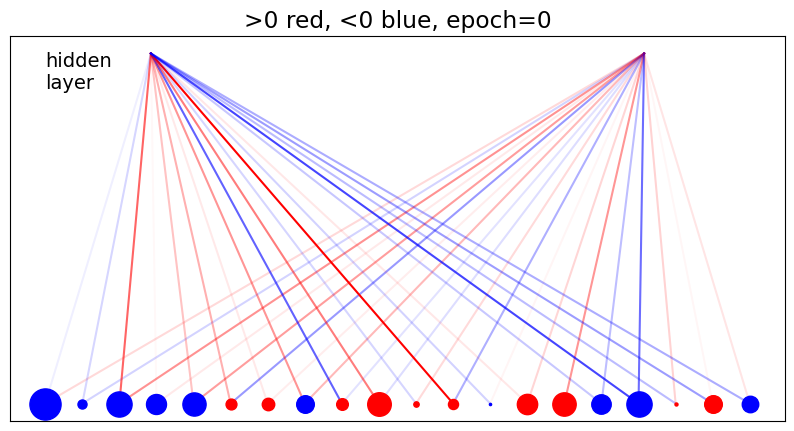

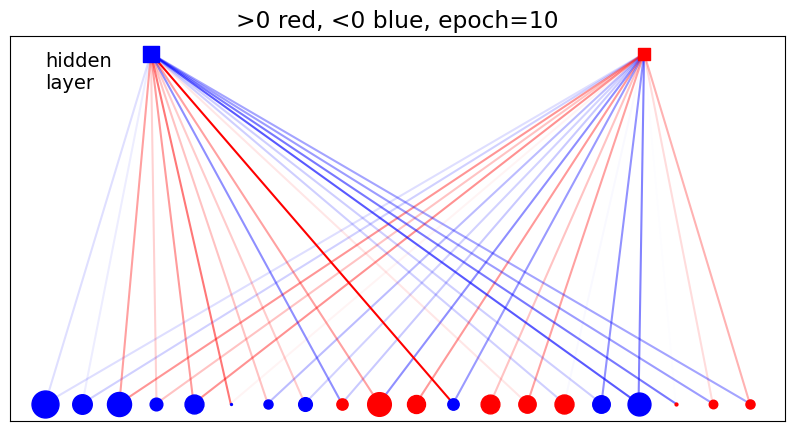

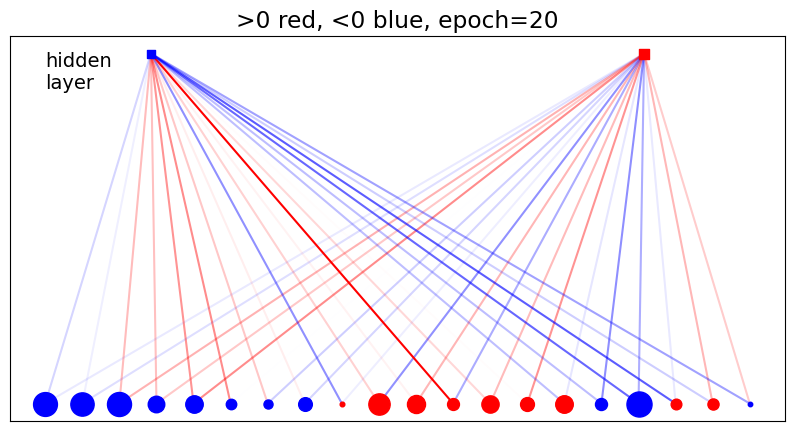

In [14]:
#WITH CENTERING TRICK


for i in range(len(opt_list)):
    opt=opt_list[i]
    for j in range(len(kk_list)):
        kk=kk_list[j]

        # sketch for multiple CD, ADAM, RMS
        # random seed for reproducibility
        np.random.seed(12345)

        plotgraph(0)



        # minibatch
        mini, m = 50, 0

        # RMSprop hyperparameters
        beta = 0.9
        eps = 1e-8


        # ADAM hyperparameters
        beta1 = 0.9
        beta2 = 0.99

        #central trick parameters
        psi_mu = 0.01
        psi_lam = 0.01
        mu = np.zeros(L)
        lam = np.zeros(M)

        #inizialitation of a b w
        w = sigma * np.random.randn(L,M)
        a = sigma * np.random.randn(L)
        b = np.zeros(M)
        
        # accuracy initialization
        Acc_tot = []
        
        #Energies + Loglikelihood inicialization
        E_RBM = np.zeros(ep)
        E_D = np.zeros(ep)
        Energies = np.zeros(ep)

        # train model
        print('===================================================')

        for epoch in range(ep):
            # aggregate normalization of batch statistics and learning rate
            l_rate_m = l_rate/mini
            batch_group=1
            vff = np.zeros_like(v0)
            for k in range(N):
                if m==0:
                    # centering trick
                    # initialize averages in miniblock
                    v_data, v_model= np.zeros((N,L)),np.zeros((N,L))
                    h_data, h_model= np.zeros((N,M)),np.zeros((N,M))

                    # initialize adam and rms parameters for every minibatch
                        # adam
                    aa = np.abs(a*0)
                    bb = np.abs(b*0)
                    ww = np.abs(w*0)
                        # rms
                    m_w,v_w,m_w_hat, v_w_hat = np.zeros((L,M)), np.zeros((L,M)), np.zeros((L,M)), np.zeros((L,M))
                    m_a,v_a,m_a_hat, v_a_hat = np.zeros(L),np.zeros(L),np.zeros(L),np.zeros(L)
                    m_b,v_b,m_b_hat, v_b_hat = np.zeros(M),np.zeros(M),np.zeros(M),np.zeros(M)

                # positive CD phase: generating h 
                h = activate(v[k],w,b,GAP)

                # negative CD phase: generating fantasy vf
                #vf = activate(h,w.T,a,GAP)
                vf = activate_backward(h, w, a, GAP) #<- new way

                # one more positive CD phase: generating fantasy h from fantasy vf 
                hf = activate(vf,w,b,GAP)

                if kk != 1: 
                    for kk in range(kk-1):
                        # negative CD phase: generating fantasy vf
                        vf = activate_backward(hf, w, a, GAP)

                        # one more positive CD phase: generating fantasy h from fantasy vf 
                        hf = activate(vf,w,b,GAP)


                v_data[k]= v[k]
                v_model[k]= vf
                h_data[k]= h
                h_model[k]= hf
                vff[k] = vf
                
                
                E_RBM[epoch] += energies(v[k],h,a,b,w)
                E_D[epoch] += energies(vf,hf,a,b,w)


                m += 1
                # minibatch
                if m==mini:

                    v_data_bg = v_data[(batch_group-1)*mini:batch_group*mini,:]
                    v_model_bg = v_model[(batch_group-1)*mini:batch_group*mini,:]
                    h_data_bg = h_data[(batch_group-1)*mini:batch_group*mini,:]                           
                    h_model_bg = h_model[(batch_group-1)*mini:batch_group*mini,:]       

                    # estimate mu_batch and lambda_batch
                    mu_batch = np.mean(v_data_bg, axis=0)
                    lam_batch = np.mean(h_data_bg, axis=0)

                    # transform the parameters with respect to the new offsets
                    a = a + psi_lam*np.dot(w,(lam_batch-lam))
                    b = b + psi_mu*np.dot(w.T,(mu_batch-mu))

                    # update the offsets using a moving average with factors psi_mu and psi_lam
                    mu = (1-psi_mu)*mu + psi_mu*mu_batch
                    lam = (1-psi_lam)*lam + psi_lam*lam_batch


                    v_data = np.sum(v_data_bg, axis=0)
                    v_model = np.sum(v_model_bg, axis=0)
                    h_data = np.sum(h_data_bg, axis=0)                              
                    h_model = np.sum(h_model_bg, axis=0)

                    vh_data = np.dot((v_data_bg-mu).T,(h_data_bg-lam))
                    vh_model = np.dot((v_model_bg-mu).T,(h_model_bg-lam))


                    # update the parameters according to the gradients
                    # case 1 vanila, case 2 ADAM, case RMSprop                    
                    if opt == 1 : 
                        dw = l_rate_m*(vh_data - vh_model)
                        da = l_rate_m*(v_data - v_model)
                        db = l_rate_m*(h_data - h_model)
                        # basic step of vanilla gradient descent, from eq.(211)
                        w = w + dw
                        a = a + da
                        b = b + db
                        m = 0


                    # for ADAM
                    if opt == 2: 
                        dw = (vh_data - vh_model)
                        da = (v_data - v_model)
                        db = (h_data - h_model)

                        m_w = beta1*m_w + (1 - beta1)*dw
                        m_a = beta1*m_a + (1 - beta1)*da
                        m_b = beta1*m_b + (1 - beta1)*db

                        v_w = beta2*v_w + (1 - beta2)*(dw**2)
                        v_a = beta2*v_a + (1 - beta2)*(da**2)
                        v_b = beta2*v_b + (1 - beta2)*(db**2)

                        m_w_hat = m_w/(1 - np.power(beta1, m))
                        m_a_hat = m_a/(1 - np.power(beta1, m))
                        m_b_hat = m_b/(1 - np.power(beta1, m))

                        v_w_hat = v_w/(1 - np.power(beta2, m))
                        v_a_hat = v_a/(1 - np.power(beta2, m))
                        v_b_hat = v_b/(1 - np.power(beta2, m))

                        w += l_rate_m*m_w_hat/(np.sqrt(v_w_hat + eps))
                        a += l_rate_m*m_a_hat/(np.sqrt(v_a_hat + eps))
                        b += l_rate_m*m_b_hat/(np.sqrt(v_b_hat + eps))
                        m = 0                    


                    # for RMSprop
                    if opt ==3:
                        dw = (vh_data - vh_model)
                        da = (v_data - v_model)
                        db = (h_data - h_model)

                        ww = beta*ww + (1 - beta)*np.square(dw)
                        aa = beta*aa + (1 - beta)*np.square(da)
                        bb = beta*bb + (1 - beta)*np.square(db) 

                        w += (l_rate_m*dw)/(np.sqrt(ww + eps))
                        a += (l_rate_m*da)/(np.sqrt(aa + eps))
                        b += (l_rate_m*db)/(np.sqrt(bb + eps))
                        m = 0


            # energies and log-likelihood
            Energies=energies(v,h_possible,a,b,w)
            vector_loglikelihood[i][j][epoch] = LL(v_possible, h_possible, a, b, w, N, Energies)
            
            # randomize the order of input data
            np.random.shuffle(v)

            # decrease the learning rate (here as a power law)
            l_rate = l_rate / (0.01 * l_rate + 1)
            
            vff[vff==-1]=0
            eps,_,_ = accuracy(v0,vff)
            Acc_tot.append(eps)
            
            
            

            if epoch%10==9:
                plotgraph(epoch+1)

            vector_results_a[i, j]=a
            vector_results_b[i, j]=b
            vector_results_w[i, j]=w

####  Weights $w_{iμ}$ of each hidden unit μ in an A×G table, red means positive and blue means negative weight.

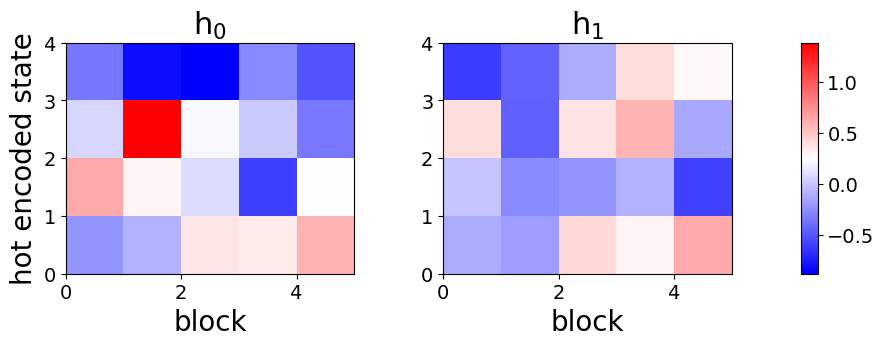

In [56]:
gridspec = {'width_ratios' : [1,1,0.06]}
fig, ax = plt.subplots(1,M+1, figsize=(10,3), gridspec_kw = gridspec)
for mu in range(M):
    temp=np.reshape(w[:,mu],(n_hot_encoding,n_chunk))
    ydim,xdim= temp.shape
    x=np.arange(xdim+1) ; y=np.arange(ydim+1)
    ecia = ax[mu].pcolormesh(x, y, temp, shading='flat', vmin=w.min(), vmax=w.max(), cmap='bwr')
    ax[mu].set_title("h$_"+str(mu)+'$', size = 22)
    ax[mu].set_aspect('equal')
    ax[mu].set_xlabel('block', size = 20)
ax[0].set_ylabel('hot encoded state', size = 20)

for axes in ax[:-1]:
    axes.set_aspect(1)
cax = ax[-1]
plt.colorbar(ecia,cax=cax)
cax.set_aspect(6)
# plt.savefig('log-hu', dpi='figure', format=None, bbox_inches='tight', pad_inches=0.05)
plt.show()

## Test: Decostruction

In [16]:
vector_results_v1=np.zeros((len(opt_list), len(kk_list), N, L))
for i in range(len(opt_list)):
    for j in range(len(kk_list)):

        w=vector_results_w[i, j]
        a=vector_results_a[i, j]
        b=vector_results_b[i, j]
        ampl=1

        # original, non-reshuffled data in v0
        v1 = np.zeros_like(v0)

        for k in range(N): 

            # positive CD phase: generating h 
            h = activate(v0[k],w,b,ampl*GAP)

            # negative CD phase: generating fantasy vf with low T == large GAP
            #v1[k] = activate(h,w.T,a,ampl*GAP)
            v1[k] = activate_backward(h, w, a, ampl*GAP)


        vector_results_v1[i,j]=v1
        
# difference between fantasy and data
diff = (v1 - v0)/2
str0 = fname+'_M'+str(M)+'-mini'+str(mini)
np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')  


def is_one(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: gold;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

N1=20
df0 = pd.DataFrame(v0[:N1])
df1 = pd.DataFrame(((v1[:N1]-vmin)/(1-vmin)).astype(int))

df0s = df0.style.set_table_attributes("style='display:inline'")
df1s = df1.style.set_table_attributes("style='display:inline'")
df0s.applymap(is_one)
df1s.applymap(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)
df1s.set_caption('Deconstructed').set_table_styles(sty)
display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
7,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


In [57]:
# final accuracy
v1[v1==-1]=0
MSE,_,_ = accuracy(v0,v1)
print('Advesarial Accuracy MSE', MSE)

Advesarial Accuracy MSE 0.0016739299999999967


## Test: Log Likelihood Graph

Text(0.5, 0, 'Epoch')

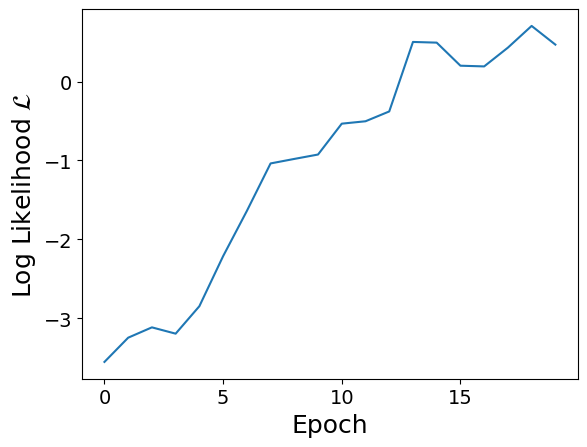

In [19]:
epoch_steps= np.arange(ep)
plt.plot(epoch_steps, vector_loglikelihood[0][0][:])
plt.ylabel('Log Likelihood $\mathcal{L}$', size = 18)
plt.xlabel('Epoch', size = 18)

# np.savetxt('ll_rms_kk7_ep20_nc', vector_loglikelihood)

## Test: Adversarial Accuracy MSE Graph

Text(0.5, 0, 'Epoch')

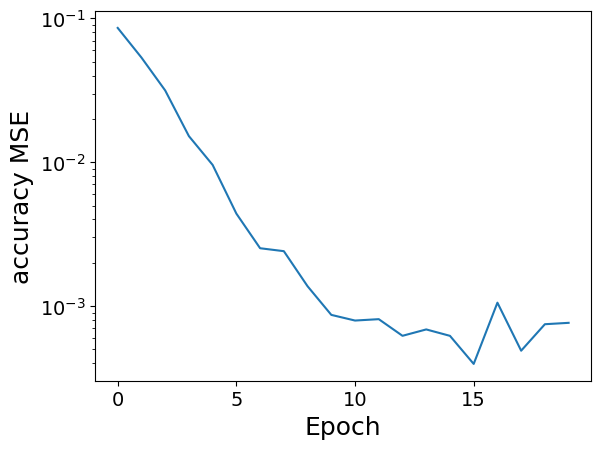

In [24]:
epoch_steps= np.arange(ep)
plt.plot(epoch_steps, Acc_tot)
plt.yscale('log')
plt.ylabel('accuracy MSE', size = 18)
plt.xlabel('Epoch', size = 18)

# np.savetxt('load', Acc_tot)